## Vision Transformer (ViT)

### Trabajo Práctico N° 2

### Christopher Charaf

## Tareas:

1. **Implementar la arquitectura de un Vision Transformer** 

2. **Ingresar y ajustar los parametros del modelo**

3. **Probar diferentes técnicas de data augmentation** 

### Imports

In [67]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import numpy as np
import math
import os
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torch
from torchvision import datasets, transforms
import torch._dynamo
torch._dynamo.config.suppress_errors = True
from trainer import Trainer
import pickle

##Import timm para implementar ViT 
##https://pprp.github.io/timm/models/vision-transformer/
from timm.layers import DropPath             



### Definicion de clases

In [68]:
device =  'cpu'
print('Dispositivo: ',device)
print('Torch version: ',torch.__version__)

# La configuración, carga y preprocesamiento
class ConfigPreprocess:
    def __init__(self, device: str, img_path: str, img_size: int, patch_size: int):
        self.device = device
        self.img_path = img_path
        self.img_size = img_size
        self.patch_size = patch_size
        self.test_img = self.load_image()

    def load_image(self):
        return TF.to_tensor(Image.open(self.img_path).resize((self.img_size, self.img_size))).unsqueeze(0).to(self.device)

    def extract_patches(self, image: Tensor) -> Tensor:
        patches = image.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(image.shape[0], -1, self.patch_size, self.patch_size)
        return patches
    

class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

# Clase del TP1
class PositionalEncodingLearned(nn.Module):
    """
    Positional embedding aprendido para los parches de imagen.
    Este módulo añade embeddings posicionales aprendidos a los embeddings de entrada.
    """
    def __init__(self, num_patches, embed_dim, dropout=0.1):
        super(PositionalEncodingLearned, self).__init__()
        self.pos_embedding = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        
        self._reset_parameters()
        
        # Dropout después de sumar los embeddings posicionales
        self.dropout = nn.Dropout(p=dropout)
    
    def _reset_parameters(self):
        """Inicializa los parámetros de embedding posicional"""
        nn.init.normal_(self.pos_embedding, std=0.02)
    
    def forward(self, x):
        """
        Agrega los embeddings aprendidos a los de entrada.
        
        Args:
            x: Tensor de embeddings de entrada [batch_size, num_patches, embed_dim]
        
        Returns:
            x: Tensor con embeddings posicionales añadidos [batch_size, num_patches, embed_dim]
        """
        x = x + self.pos_embedding
        return self.dropout(x)

Dispositivo:  cpu
Torch version:  2.5.1


### Transformer Encoder

### 1. **Implementar la arquitectura de un Vision Transformer** 

In [69]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0, proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim =dim / num_heads

        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(proj_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v =qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [70]:
class mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [71]:
class Block(nn.Module):

    def __init__(
        self,
        dim,
        num_heads,
        mlp_ratio=4,
        qkv_bias=False,
        qk_scale=None,
        drop=0,
        attn_drop=0,
        drop_path=0,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm,
    ):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            attn_drop=attn_drop,
            proj_drop=drop,
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x
        

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size=224,
        patch_size=16,
        in_channels=3,
        num_classes=10,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.0,
        norm_layer=nn.LayerNorm,
    ):
        super(VisionTransformer, self).__init__()
        # Patch embedding layer: splits image into patches and projects to embedding dimension
        self.patch_embed = PatchEmbedding(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=embed_dim,
        )
        num_patches = self.patch_embed.num_patches

        # Learnable [CLS] token for classification
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Learnable positional encoding for each patch + [CLS] token
        self.pos_embed = PositionalEncodingLearned(
            num_patches=num_patches + 1,  # +1 for [CLS] token
            embed_dim=embed_dim,
            dropout=drop_rate,
        )

        # Dropout after adding positional encoding
        self.pos_drop = nn.Dropout(p=drop_rate)

        # Stochastic depth decay rule for each transformer block
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]

        # Stack of transformer encoder blocks
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                drop_path=dpr[i],
                norm_layer=norm_layer,
            )
            for i in range(depth)
        ])

        # Final normalization layer before classification head
        self.norm = norm_layer(embed_dim)

        # Classification head: projects [CLS] token to class logits
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        # Initialize [CLS] token
        nn.init.normal_(self.cls_token, std=0.02)

    def forward_features(self, x):
        B = x.shape[0]
        # Convert image to patch embeddings
        x = self.patch_embed(x)
        # Expand and prepend [CLS] token to patch embeddings
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, 1 + num_patches, embed_dim)
        # Add positional encoding
        x = self.pos_embed(x)
        # Pass through transformer encoder blocks
        for block in self.blocks:
            x = block(x)
        # Apply final normalization
        x = self.norm(x)
        # Return only the [CLS] token representation
        return x[:, 0]

    def forward(self, x):
        # Forward pass: extract features and classify
        x = self.forward_features(x)
        x = self.head(x)
        return x

### 3. **Probar diferentes técnicas de data augmentation**

#### Data augmentation

In [ ]:
# Define transformations for the input data
transform = transforms.Compose([
    #transforms.Resize((256, 256)), ## no vale la pena, ya que las imagenes de CIFAR10 son de 32x32
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    #transforms.RandomRotation(3), # Se puede agregar para aumentar la variabilidad de las imagenes, pero en la practica no es necesario y nuestras metricas no mejoran
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#### Cargar dataset

In [74]:
# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [75]:
def get_folder_size(folder_path :os.PathLike) -> str:
    total_size = 0
    for dirpath, _, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)

            if not os.path.islink(file_path):
                total_size += os.path.getsize(file_path)

    if total_size == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB")
    i = int(math.floor(math.log(total_size, 1024)))
    p = math.pow(1024, i)
    s = round(total_size / p, 2)
    return f"{s} {size_name[i]}"


folder_path = './data'
size_in_bytes = get_folder_size(folder_path)
print(f"Tamaño de carpeta: {size_in_bytes}")

Tamaño de carpeta: 340.19 MB


### 2. **Ingresar y ajustar los parametros del modelo**

In [ ]:
'''
A continuacion ingrese los parametros del modelo

'''

num_epochs = 10

model = VisionTransformer(
    img_size=32,           # Tamaño de las imágenes de CIFAR10 (32x32)
    patch_size=4,          # Parches más pequeños para imágenes pequeñas, divide la imagen en 16 parches de 4x4
    in_channels=3,         # RGB
    num_classes=10,        # 10 clases para CIFAR10
    embed_dim=192,         # embedding dimension, puede ser menor para CIFAR10
    depth=9,               # Número de bloques transformer
    num_heads=8,           # Número de cabezas de atención
    mlp_ratio=2.0,         # Relación más pequeña para la capa MLP
    qkv_bias=True,         # Bias para las proyecciones QKV
    drop_rate=0.1,         # Dropout general
    attn_drop_rate=0.0,    # Dropout para la atención
    drop_path_rate=0.1,    # Stochastic depth rate
).to(device)

print("Parametros del modelo:", list(model.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)


model = model.to(device)

Parametros del modelo: [Parameter containing:
tensor([[[ 1.6500e-04, -1.2012e-02, -6.9771e-03, -7.0133e-03,  2.0698e-02,
          -2.5291e-02,  3.1017e-04,  5.0644e-03,  3.2090e-02,  2.1610e-02,
           4.1139e-03,  1.6651e-02,  1.9780e-02,  2.1743e-02,  2.3738e-02,
           4.3181e-02, -2.1886e-02, -1.5695e-02, -1.3517e-02, -1.9032e-02,
          -1.5194e-03,  2.6830e-02, -2.6883e-02, -3.0853e-02, -4.3394e-03,
           9.2970e-03,  3.1036e-02,  1.2403e-02,  1.1679e-02, -1.5014e-02,
           2.7846e-04, -2.0566e-02,  1.3139e-02, -1.0399e-02, -7.6278e-03,
          -1.0113e-02,  7.0302e-03, -4.6609e-03,  2.0252e-02, -4.7014e-02,
          -7.6670e-03,  1.9063e-02,  1.9223e-02, -1.4167e-02,  7.1346e-03,
          -8.3441e-04, -1.7550e-02, -2.1496e-02,  2.5097e-02,  3.6536e-03,
           2.9977e-02,  3.4588e-02,  8.8748e-03, -1.8633e-03, -1.4093e-02,
          -1.8574e-02, -4.1841e-02, -1.6530e-02, -1.9277e-02, -2.3945e-02,
          -5.5934e-02, -1.9616e-02,  7.4932e-04, -2.71

In [77]:
def count_parameters(model: nn.Module) -> int:
    """
    Count the number of trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.

    Returns:
        int: The total number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000

torch.cuda.empty_cache()
print("Número de parámetros: {:.2f} millones".format(count_parameters(model)))


Número de parámetros: 2.70 millones


In [78]:
trainer = Trainer(model, train_loader,test_loader,criterion,optimizer, device)

for epoch in range(num_epochs):

    trainer.train_model(use_amp=True)
    
    #scheduler.step()

loss 1.07023: 100%|██████████| 98/98 [04:56<00:00,  3.03s/it]


In [79]:
def evaluate_model(model, data_loader):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images = images.to(device).float()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    return accuracy, precision, recall, f1

# Evaluar el modelo
accuracy, precision, recall, f1 = evaluate_model(model, test_loader)

100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


In [80]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.65
Precision: 0.66
Recall: 0.65
F1 score: 0.64


In [81]:
train_dataset.data[0].shape

(32, 32, 3)

In [ ]:
with open('data/cifar-10-batches-py/batches.meta', 'rb') as f:
    meta = pickle.load(f, encoding='latin1')

# Imprimir los nombres de las clases
class_names = meta['label_names']
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


  0%|          | 0/20 [00:01<?, ?it/s]


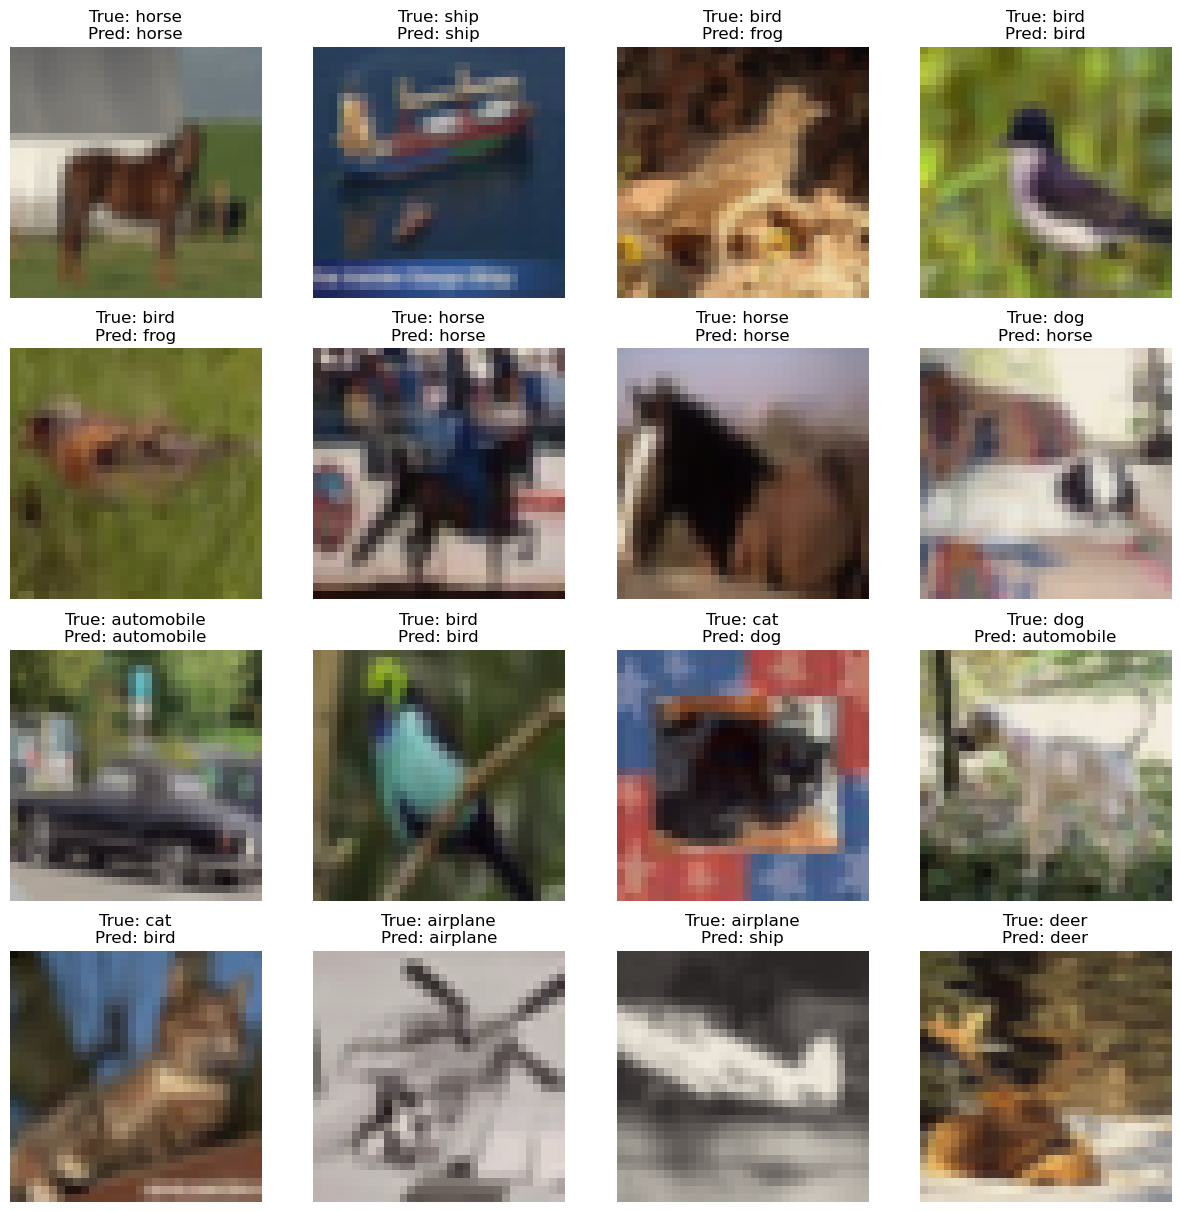

In [ ]:
# Mostrar algunas imágenes de prueba con sus etiquetas verdaderas y predicciones
def visualize_classification(model, data_loader, class_names, num_images=16):
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(15, 15))

    with torch.no_grad():
        for batch in tqdm(data_loader):
            inputs, labels = batch
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f'True: {class_names[labels[j]]}\nPred: {class_names[preds[j]]}')
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                if images_so_far == num_images:
                    return


visualize_classification(model, test_loader, class_names, num_images=16)
plt.show()